 # Initiation

### Intro

This a supervised and classification machine learning project that aims to develop an application credit scorecard using a labeled dataset with information of 10,000 clients that were granted a loan and other dataset with information of 5,000 application that were rejected.

Decision Tree and Logistic Regression were the algorithms selected to calculated the probabilities of default for each customer. Cross validation and hyperparameter tunning was applied to get robust results. The best performer, chose by assessing different performance metrics like AUC, Accuracy and F1, is used to calculate the default probabilities. 

Rejection inference is apply to make sure that the final model is as less bias as possible and is more generalizable since it captures information of both accepted and rejected applications, situation that will happen in real life. 

### Packages

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# Metrics
# Splitting data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, accuracy_score, precision_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import random
from sklearn.model_selection import GridSearchCV 

from category_encoders import *

from numpy import log as ln

from imblearn.over_sampling import SMOTE 

# SQL
from pandasql import sqldf
def pysqldf(q): return sqldf(q, globals())

### WoE functioncs 

To calculate the WoE and map it to the dataframe, the function used for this project was extracted from this Github repository:

https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb

Below are the two functions extracted.

The function below named mono_bin return a dataframe with all the step to calculate the WoE, the WoE and the IV

In [80]:
# This function create a new dataframe with all the steps to calculate the woe and also the IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 5
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

Map the WoE to the Dataframe

In [81]:
# Function to map each WoE value to the Train, Test and Rejects
def transf(df):
    for var in transform_vars_list:
        small_df = final_iv[final_iv['VAR_NAME'] == var]
        transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
        replace_cmd = ''
        replace_cmd1 = ''
        for i in sorted(transform_dict.items()):
            replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
            replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
        replace_cmd = replace_cmd + '0'
        replace_cmd1 = replace_cmd1 + '0'
        if replace_cmd != '0':
            try:
                df[var] = df[var].apply(lambda x: eval(replace_cmd))
            except:
                df[var] = df[var].apply(lambda x: eval(replace_cmd1))
    return df

Reading the data

In [82]:
# Importing datasets 
accepts = pd.read_csv('ACCEPTS.csv', sep = ',')
rejects = pd.read_csv('rejects.csv', sep = ',')

# Data summary

Both data set were read fine. 

In [83]:
# Checking general 
accepts.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,Days_late,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio,Default_45
0,250263,1,1,11,5,6,7,1,2,0,1,0,NaN,1.438518,-0.259085,1.781040,0.860269,0.513980,0
1,250290,1,2,6,4,5,1,1,2,1,1,0,1.498183,0.204811,0.383312,1.107163,-0.718249,1.796590,0
2,250249,2,3,11,5,7,7,1,2,1,1,0,-0.241731,-0.852651,-0.732430,1.406664,1.122930,-0.768631,0
3,249516,3,3,10,4,2,4,1,2,0,1,168,NaN,-0.676407,-0.057350,0.957412,-1.702482,0.513980,1
4,249827,1,3,5,2,4,4,1,3,0,1,0,NaN,-0.412042,-0.574648,-0.390342,0.910077,-0.768631,0


In [84]:
rejects.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,Has_FICO,Business_channel,FICO_Score,Loan_amount,Monthly_income,Age,Gearing_coefficient,Max_gearing_ratio
0,305932,3,3,14,2,1,5,1,1,1,1,-0.030455,-0.323920,-0.605449,-1.064220,1.028210,-0.768631
1,305764,1,4,7,1,6,4,1,2,1,1,0.715222,5.668368,1.299572,0.807662,1.081778,1.796590
2,305971,1,4,10,4,5,4,1,4,1,3,0.764933,-0.750782,0.434027,-0.390342,-0.969416,1.796590
3,305664,1,5,14,2,2,5,3,3,1,1,-1.347818,-0.852651,-0.490122,-0.989344,1.046303,-0.768631
4,305639,1,4,15,1,5,4,1,3,1,2,1.634890,3.200955,0.561380,0.583036,0.088464,1.796590


In [85]:
# Checking size
print(accepts.shape)
print(rejects.shape)

(10000, 19)
(5000, 17)


Below we can see that only FICO_Score has null values.

In [86]:
# Checking general info
accepts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   V1                   10000 non-null  int64  
 2   V2                   10000 non-null  int64  
 3   V3                   10000 non-null  int64  
 4   V4                   10000 non-null  int64  
 5   V5                   10000 non-null  int64  
 6   V6                   10000 non-null  int64  
 7   V7                   10000 non-null  int64  
 8   V8                   10000 non-null  object 
 9   Has_FICO             10000 non-null  int64  
 10  Business_channel     10000 non-null  int64  
 11  Days_late            10000 non-null  int64  
 12  FICO_Score           5528 non-null   float64
 13  Loan_amount          10000 non-null  float64
 14  Monthly_income       10000 non-null  float64
 15  Age                  10000 non-null  

Below we can see that only FICO_Scorehas null values in the rejects dataset too.

In [87]:
rejects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5000 non-null   int64  
 1   V1                   5000 non-null   int64  
 2   V2                   5000 non-null   int64  
 3   V3                   5000 non-null   int64  
 4   V4                   5000 non-null   int64  
 5   V5                   5000 non-null   int64  
 6   V6                   5000 non-null   int64  
 7   V7                   5000 non-null   int64  
 8   V8                   5000 non-null   object 
 9   Has_FICO             5000 non-null   int64  
 10  Business_channel     5000 non-null   int64  
 11  FICO_Score           2914 non-null   float64
 12  Loan_amount          5000 non-null   float64
 13  Monthly_income       5000 non-null   float64
 14  Age                  5000 non-null   float64
 15  Gearing_coefficient  5000 non-null   f

The target variable is unbalanced but not too much. If the performance is not good, an oversampling method can be consider. 

0    7636
1    2364
Name: Default_45, dtype: int64
0    0.7636
1    0.2364
Name: Default_45, dtype: float64


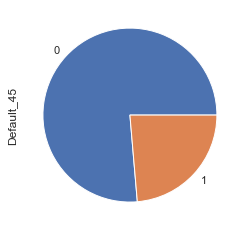

In [88]:
# Checking if target is balanced
print(accepts['Default_45'].value_counts())
print(accepts['Default_45'].value_counts(normalize=True))
accepts['Default_45'].value_counts(normalize=True).plot(kind='pie')

# Preprocessing

## Data types

As stated in the Data Description, al variables starting with 'V' are categorical and Business channel as well so all names will be put in a list and its data type transformed. 

Categorical variables

In [89]:
# All features that have v are categorical
v = accepts.filter(regex = 'V').columns

In [90]:
# Creating list with all categirical names
categorical = v.to_list()
categorical.append('Business_channel')

In [91]:
# ACCEPTS - Converting numerical that really are categorical
accepts[categorical] = accepts[categorical].astype('str')

# REJECTS
rejects[categorical] = rejects[categorical].astype('str')

Numerical variables 

In [92]:
# Creating list with numerical names
numerical = list(set(accepts.columns).difference(categorical))
# Removing ID
numerical.remove('ID')

## Missing values

As shown below, the only variable with Null obeservations is FICO_Score. Since it's a score, those null observations will be replace with 0. Replacing it with the mean was discarded because it might give false information whereas the 0 is more neutral. 
The observations with Null won't be dropped either because they represent over 40.7% of both Accepts and Rejects data sets. 

In [93]:
# ACCEPTS - Missing data
total = accepts.isnull().sum().sort_values(ascending=False)
percent = (accepts.isnull().sum()/accepts.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
FICO_Score,4472,0.4472
Default_45,0,0.0000
V8,0,0.0000
V1,0,0.0000
V2,0,0.0000
V3,0,0.0000
V4,0,0.0000
V5,0,0.0000
V6,0,0.0000
V7,0,0.0000


In [94]:
# REJECT Missing data
total = rejects.isnull().sum().sort_values(ascending=False)
percent = (rejects.isnull().sum()/rejects.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
FICO_Score,2086,0.4172
Max_gearing_ratio,0,0.0000
V7,0,0.0000
V1,0,0.0000
V2,0,0.0000
V3,0,0.0000
V4,0,0.0000
V5,0,0.0000
V6,0,0.0000
V8,0,0.0000


In [95]:
# Replacing missing values
accepts['FICO_Score'].replace(np.nan, 0, inplace = True)
rejects['FICO_Score'].replace(np.nan, 0, inplace = True)

In [96]:
# Checking if missing were replaced
print(accepts.isna().sum().sum())
print(rejects.isna().sum().sum())

0
0


## Data Exploraiton

### Numerical

Accepts

#### Correlation:

On the Correlation graph below it can be seen that FICO score and Age have a strong negative correlation. From that, it can be infer that the older one is and the higher its Fico Score, the lower the probability of defaulting. 

On the other hand, Days_late, as expected because the target derivated from there, is highly correlated with the target variable 'Default 45'. 

In [97]:
numerical.append('Days_late')
corr_target = accepts[numerical]
corr_target['Default_45'] = accepts['Default_45']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


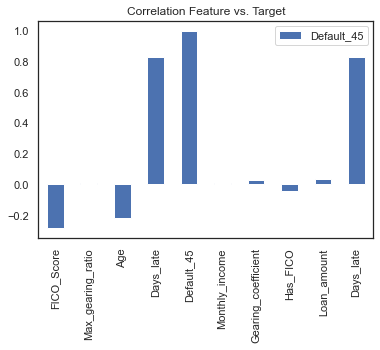

In [98]:
corr_target2 = pd.DataFrame(corr_target.corr()['Default_45'])
# corr_target2.drop(columns='Default_45', inplace = True) 
corr_target2.plot(kind= 'bar', title='Correlation Feature vs. Target')

Correlation between variables

The table below shows the different correlations between variables. Only Monthly_income and Max_gearing_ratio has a correlation higher than 0.5 but not high enough to drop one of them due to multiocolinairty. 

In [99]:
accepts[numerical].corr()

,FICO_Score,Max_gearing_ratio,Age,Days_late,Default_45,Monthly_income,Gearing_coefficient,Has_FICO,Loan_amount,Days_late
FICO_Score,1.000000,-0.117498,0.381036,-0.262570,-0.285714,-0.091917,-0.100496,-0.054680,-0.152488,-0.262570
Max_gearing_ratio,-0.117498,1.000000,-0.072083,0.013376,0.007162,0.581486,-0.334070,0.318012,0.448510,0.013376
Age,0.381036,-0.072083,1.000000,-0.199952,-0.219031,-0.073353,0.105049,0.156263,-0.060464,-0.199952
Days_late,-0.262570,0.013376,-0.199952,1.000000,0.829405,0.014527,0.040702,-0.039448,0.055334,1.000000
Default_45,-0.285714,0.007162,-0.219031,0.829405,1.000000,0.009852,0.030017,-0.044885,0.038068,0.829405
Monthly_income,-0.091917,0.581486,-0.073353,0.014527,0.009852,1.000000,-0.191135,0.217441,0.420793,0.014527
Gearing_coefficient,-0.100496,-0.334070,0.105049,0.040702,0.030017,-0.191135,1.000000,0.131668,0.162239,0.040702
Has_FICO,-0.054680,0.318012,0.156263,-0.039448,-0.044885,0.217441,0.131668,1.000000,0.128469,-0.039448
Loan_amount,-0.152488,0.448510,-0.060464,0.055334,0.038068,0.420793,0.162239,0.128469,1.000000,0.055334
Days_late,-0.262570,0.013376,-0.199952,1.000000,0.829405,0.014527,0.040702,-0.039448,0.055334,1.000000


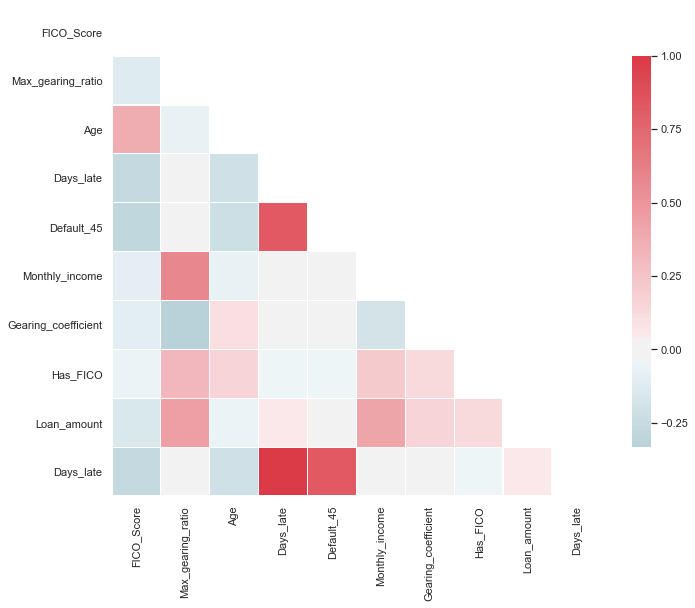

In [100]:
sns.set(style="white")

# Compute the correlation matrix
corr =  accepts[numerical].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

#### Distribution of continoues variables

In [101]:
numerical.remove('Days_late')
numerical.remove('Default_45')

The variables doesn't seem to have a normal distribution. Only FICO_score but it's due the missing replacement. 

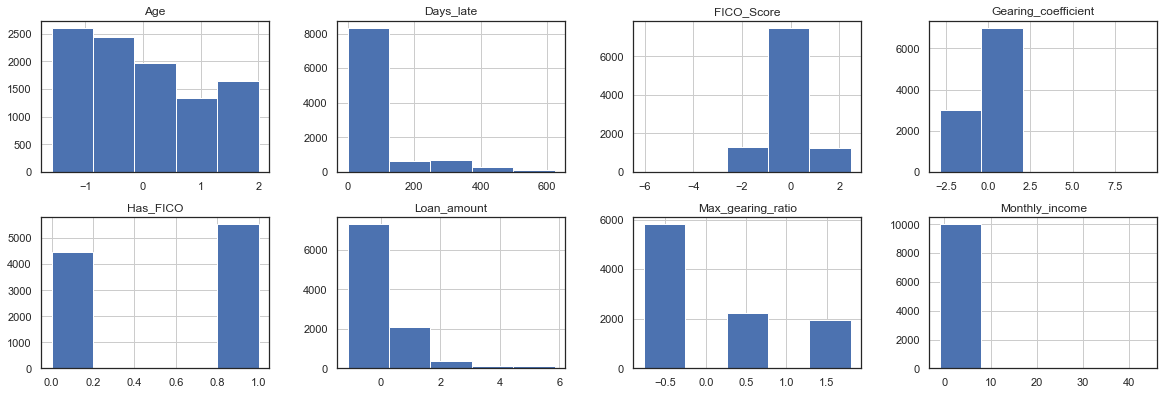

In [102]:
# Seeing distribution
accepts[numerical].hist(bins=5, figsize=(20, 10), layout=(3, 4));

It can be seen that there are outliers in different variables. These will be hanlde in the categorization of the variables by the WoE.

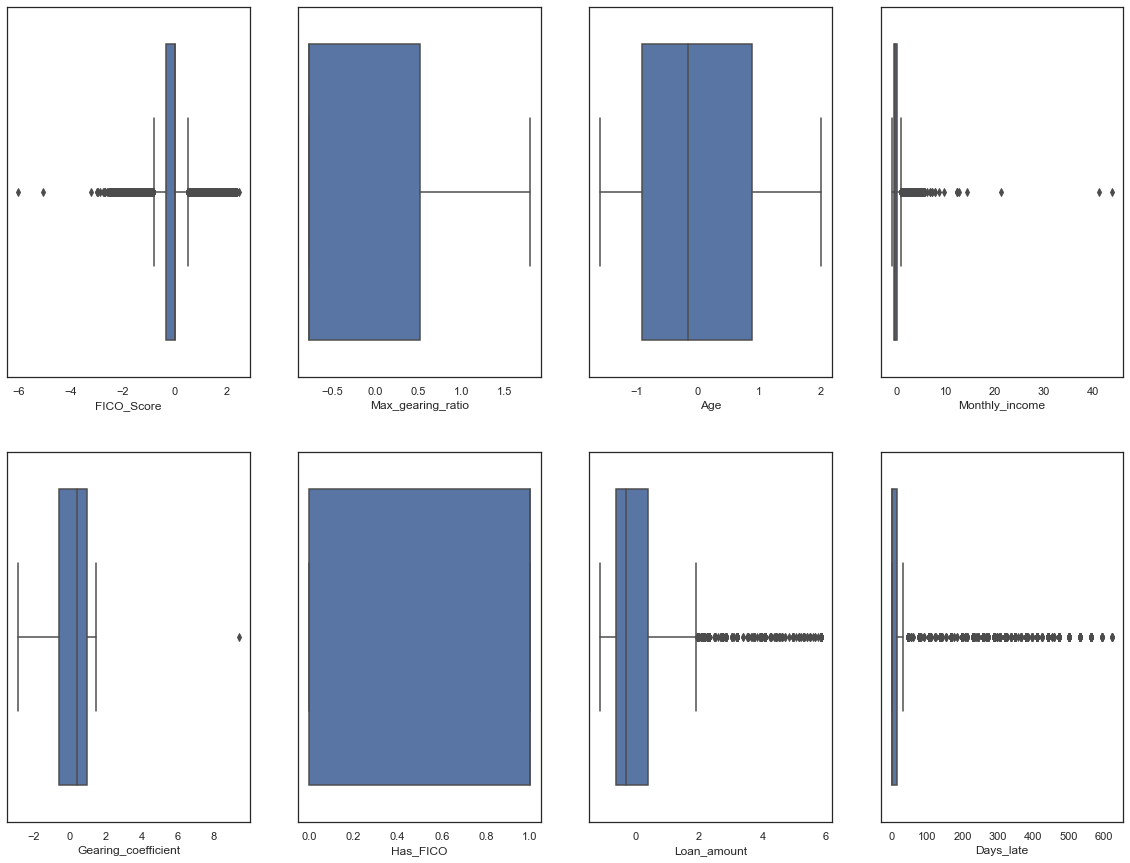

In [103]:
# ACCEPTS - Visualizing frequency of categorical variablest
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
for variable, subplot in zip(accepts[numerical], ax.flatten()):
    sns.boxplot(accepts[variable], ax=subplot)

Rejects

In [104]:
numerical.remove('Days_late')

The rejected applications seem to have a similar distribution than the accepted.

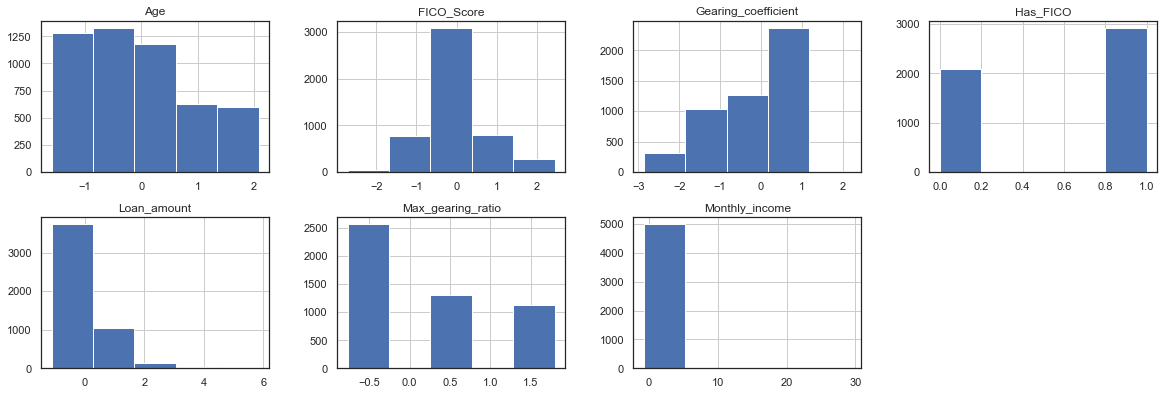

In [105]:
# Checking distribution of rejects
rejects[numerical].hist(bins=5, figsize=(20, 10), layout=(3, 4));

The data has outliers as well.

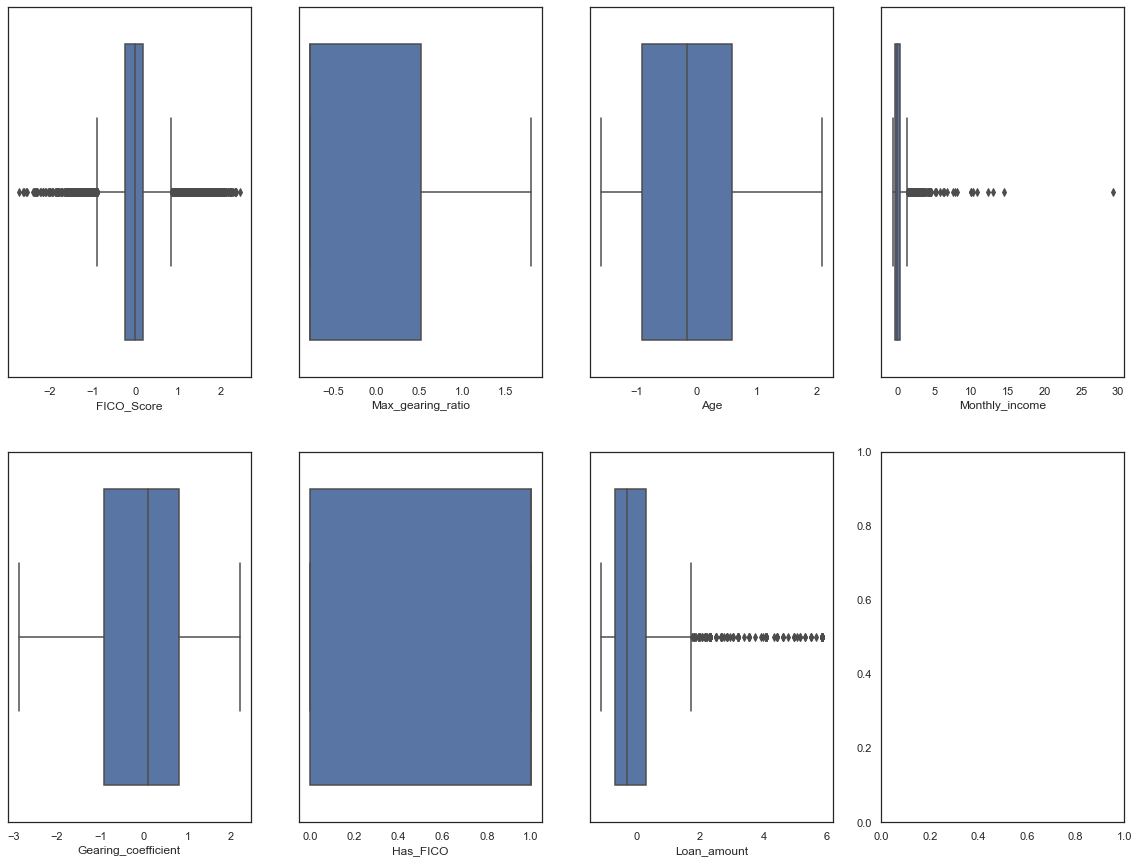

In [106]:
# ACCEPTS - Visualizing frequency of categorical variablest
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
for variable, subplot in zip(rejects[numerical], ax.flatten()):
    sns.boxplot(rejects[variable], ax=subplot)

### Categorical

Accepts

There are certainly categorize that absorb the majority of observations. There is not a clear pattern. 

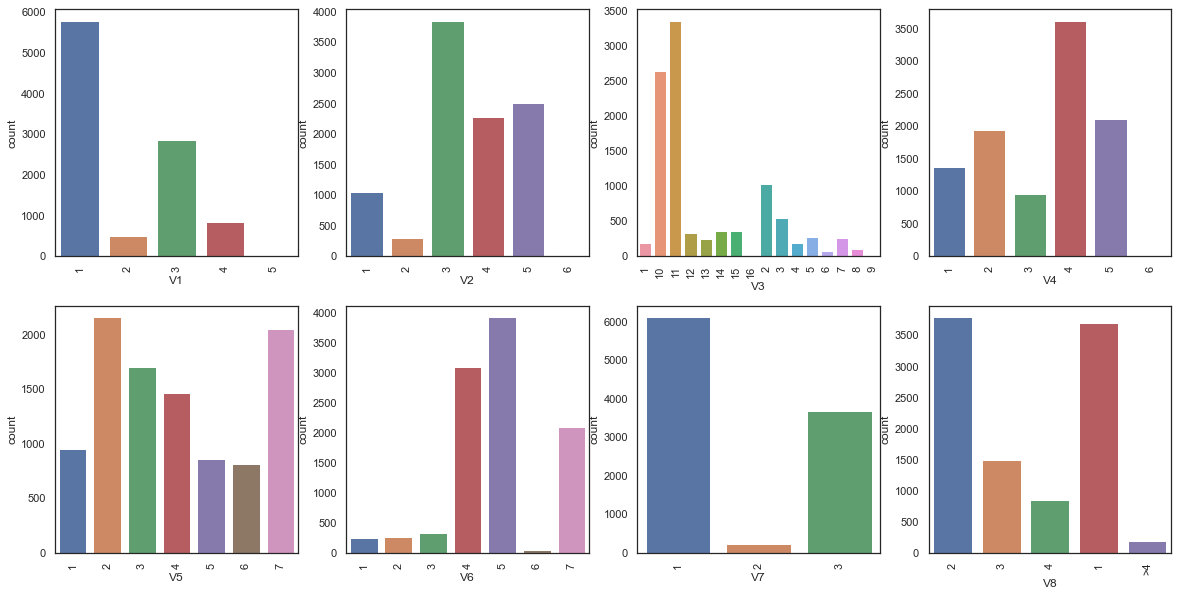

In [107]:
# ACCEPTS - Visualizing frequency of categorical variablest
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(accepts[v], ax.flatten()):
    sns.countplot(accepts[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Rejects

The rejected application seem to have similar preference or belong to the same categories than the accepted. 

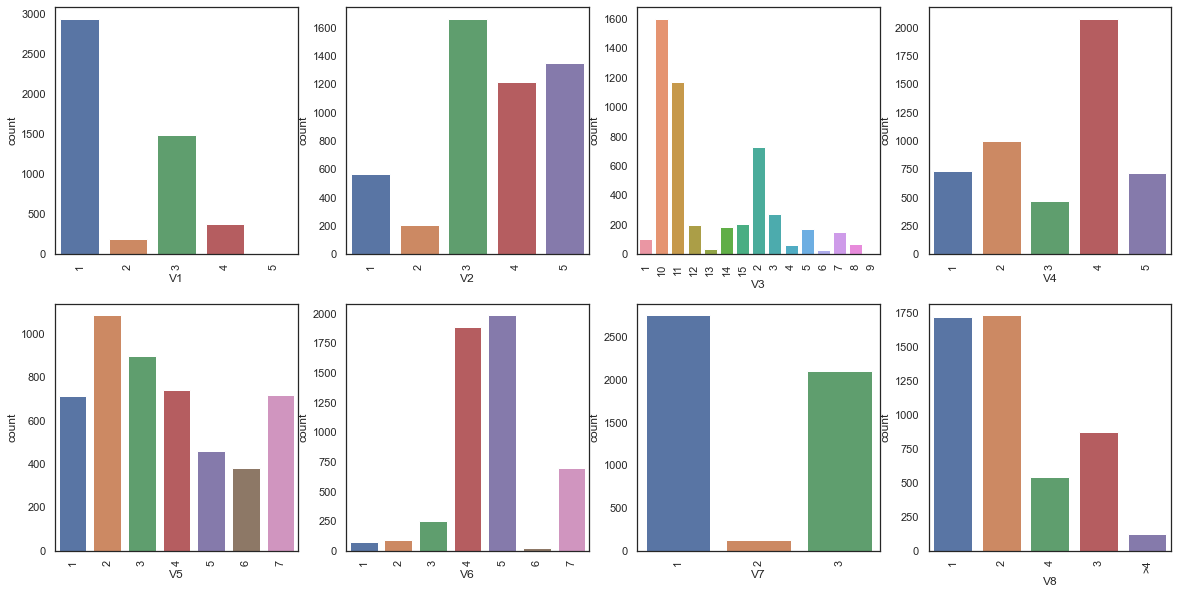

In [108]:
# REJECTS - Visualizing frequency of categorical variablest
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for variable, subplot in zip(rejects[v], ax.flatten()):
    sns.countplot(rejects[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

## Split

The accepts dataseta is splitted into Train and Test so the model learns in the train and then is tested in unseen data. 
The Test set has 30% of all observation meaning 3.000 observations. 

The Days_late is dropped because the target variable comes from that feature and the IDs are dropped as well. 

In [109]:
# Saving target variable
y = accepts['Default_45']
accepts.drop(columns=['Default_45'], inplace=True)

In [110]:
# Dropping a completely correlated variable to the target variable
accepts.drop(columns=['Days_late'], inplace=True)

In [111]:
# Splitting Dataframe into Train and Test 
X_train, X_test, y_train, y_test = train_test_split(accepts, y, test_size=0.3, random_state = 123 )

In [112]:
# Deleting the ID from the train and test sets
X_train.drop(columns=['ID'], inplace=True)
X_test.drop(columns=['ID'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# WoE

### Computation

In [113]:
# Applying the WOE and IV in the training dataset
X_train_pre = X_train.copy()
final_iv, IV = data_vars(X_train_pre,y_train)

In [114]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,V1,1,1,4005,747,0.186517,3258,0.813483,0.442536,0.613328,-0.326380,0.174624
1,V1,2,2,358,59,0.164804,299,0.835196,0.034953,0.056288,-0.476482,0.174624
2,V1,3,3,2050,738,0.360000,1312,0.640000,0.437204,0.246988,0.571060,0.174624
3,V1,4,4,582,143,0.245704,439,0.754296,0.084716,0.082643,0.024769,0.174624
4,V1,5,5,5,1,0.200000,4,0.800000,0.000592,0.000753,-0.239870,0.174624
...,...,...,...,...,...,...,...,...,...,...,...,...
72,Gearing_coefficient,0.420515,0.96329,1754,408,0.232611,1346,0.767389,0.241706,0.253389,-0.047201,0.008979
73,Gearing_coefficient,0.964141,9.3873,1746,474,0.271478,1272,0.728522,0.280806,0.239458,0.159286,0.008979
74,Max_gearing_ratio,-0.768631,-0.768631,4081,931,0.228130,3150,0.771870,0.551540,0.592997,-0.072474,0.010304
75,Max_gearing_ratio,0.51398,0.51398,1560,429,0.275000,1131,0.725000,0.254147,0.212914,0.177023,0.010304


### Mapping

In [115]:
# Applying the WOE in the X_train, X_valid and X_test datasets
transform_vars_list = X_train.columns
transform_prefix = 'new_'

In [116]:
# Mapping to all data sets
X_train = transf(X_train)

X_test = transf(X_test)

# Mapping the same WoE we used for the Accepts
rejects = transf(rejects)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Feature Selection

Below are the guidelines to perform feature selection:

Less than 0.02	Not useful for prediction

0.02 to 0.1	Weak predictive Power

0.1 to 0.3	Medium predictive Power

0.3 to 0.5	Strong predictive Power

 .>0.5	Suspicious Predictive Power

Text(0, -1, 'No predictive power')

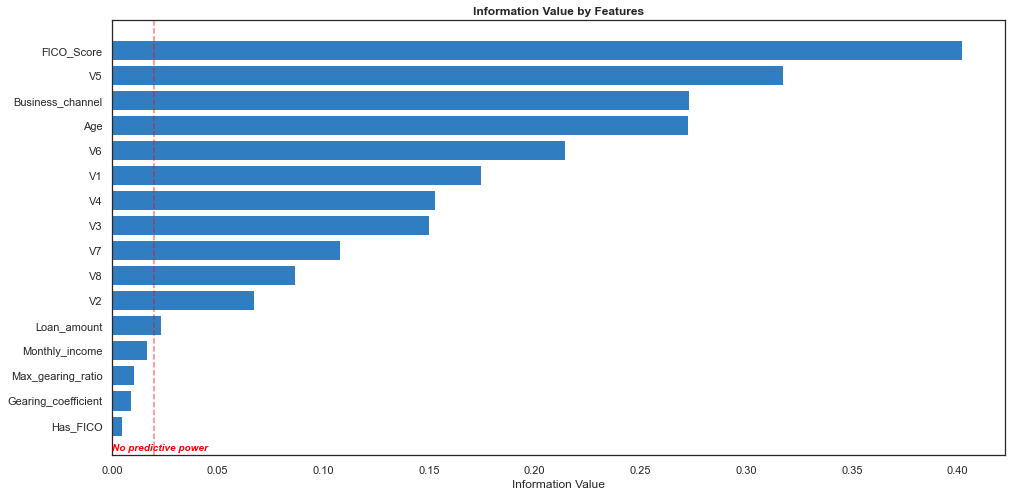

In [117]:
# Ploting the Information Value of each variable

# Sorting
IV.sort_values('IV', ascending=True, inplace=True)

# Plot IV
plt.figure(figsize=(16,8))
plt.barh(IV['VAR_NAME'], IV['IV'], color = '#317DC2')
plt.xlabel('Information Value')
plt.title('Information Value by Features', fontweight="bold")
plt.axvline(0.02, color='red', linestyle='dashed', linewidth=1.5, alpha=0.5);
plt.text(0,-1, 'No predictive power', color='red', fontweight='bold', style='italic', fontsize=10)

The graph above shows that 4 variables have very weak predictive power because are below the red line, the threshold of 0.02. Therefore, these variables  {{feat_selec}} will be dropped.

In [118]:
# Extracting the name of the variables with a predictive power less than 0.02. Those will be drop
x = IV[IV['IV'] <0.02]
feat_selec = x.iloc[:,0].tolist()

In [119]:
# Dropping the variables flagged previously 
X_train.drop(columns=feat_selec, inplace= True)
X_test.drop(columns=feat_selec, inplace= True)
rejects.drop(columns=feat_selec, inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### WoE Strength 

In [120]:
# Deleting the variables that were dropped from the final_iv that hold the WoE and all the steps to get there.
for i in feat_selec:
    final_iv = final_iv[final_iv['VAR_NAME'] != i]

The graph below shows the influence of each category within each variable to the probability of default. The higher the WoE and thus the bar, the stronger the influence and if it is negative, it means that it's negatively correlated, so instead of pushing the probability of default higher will lower it down. 

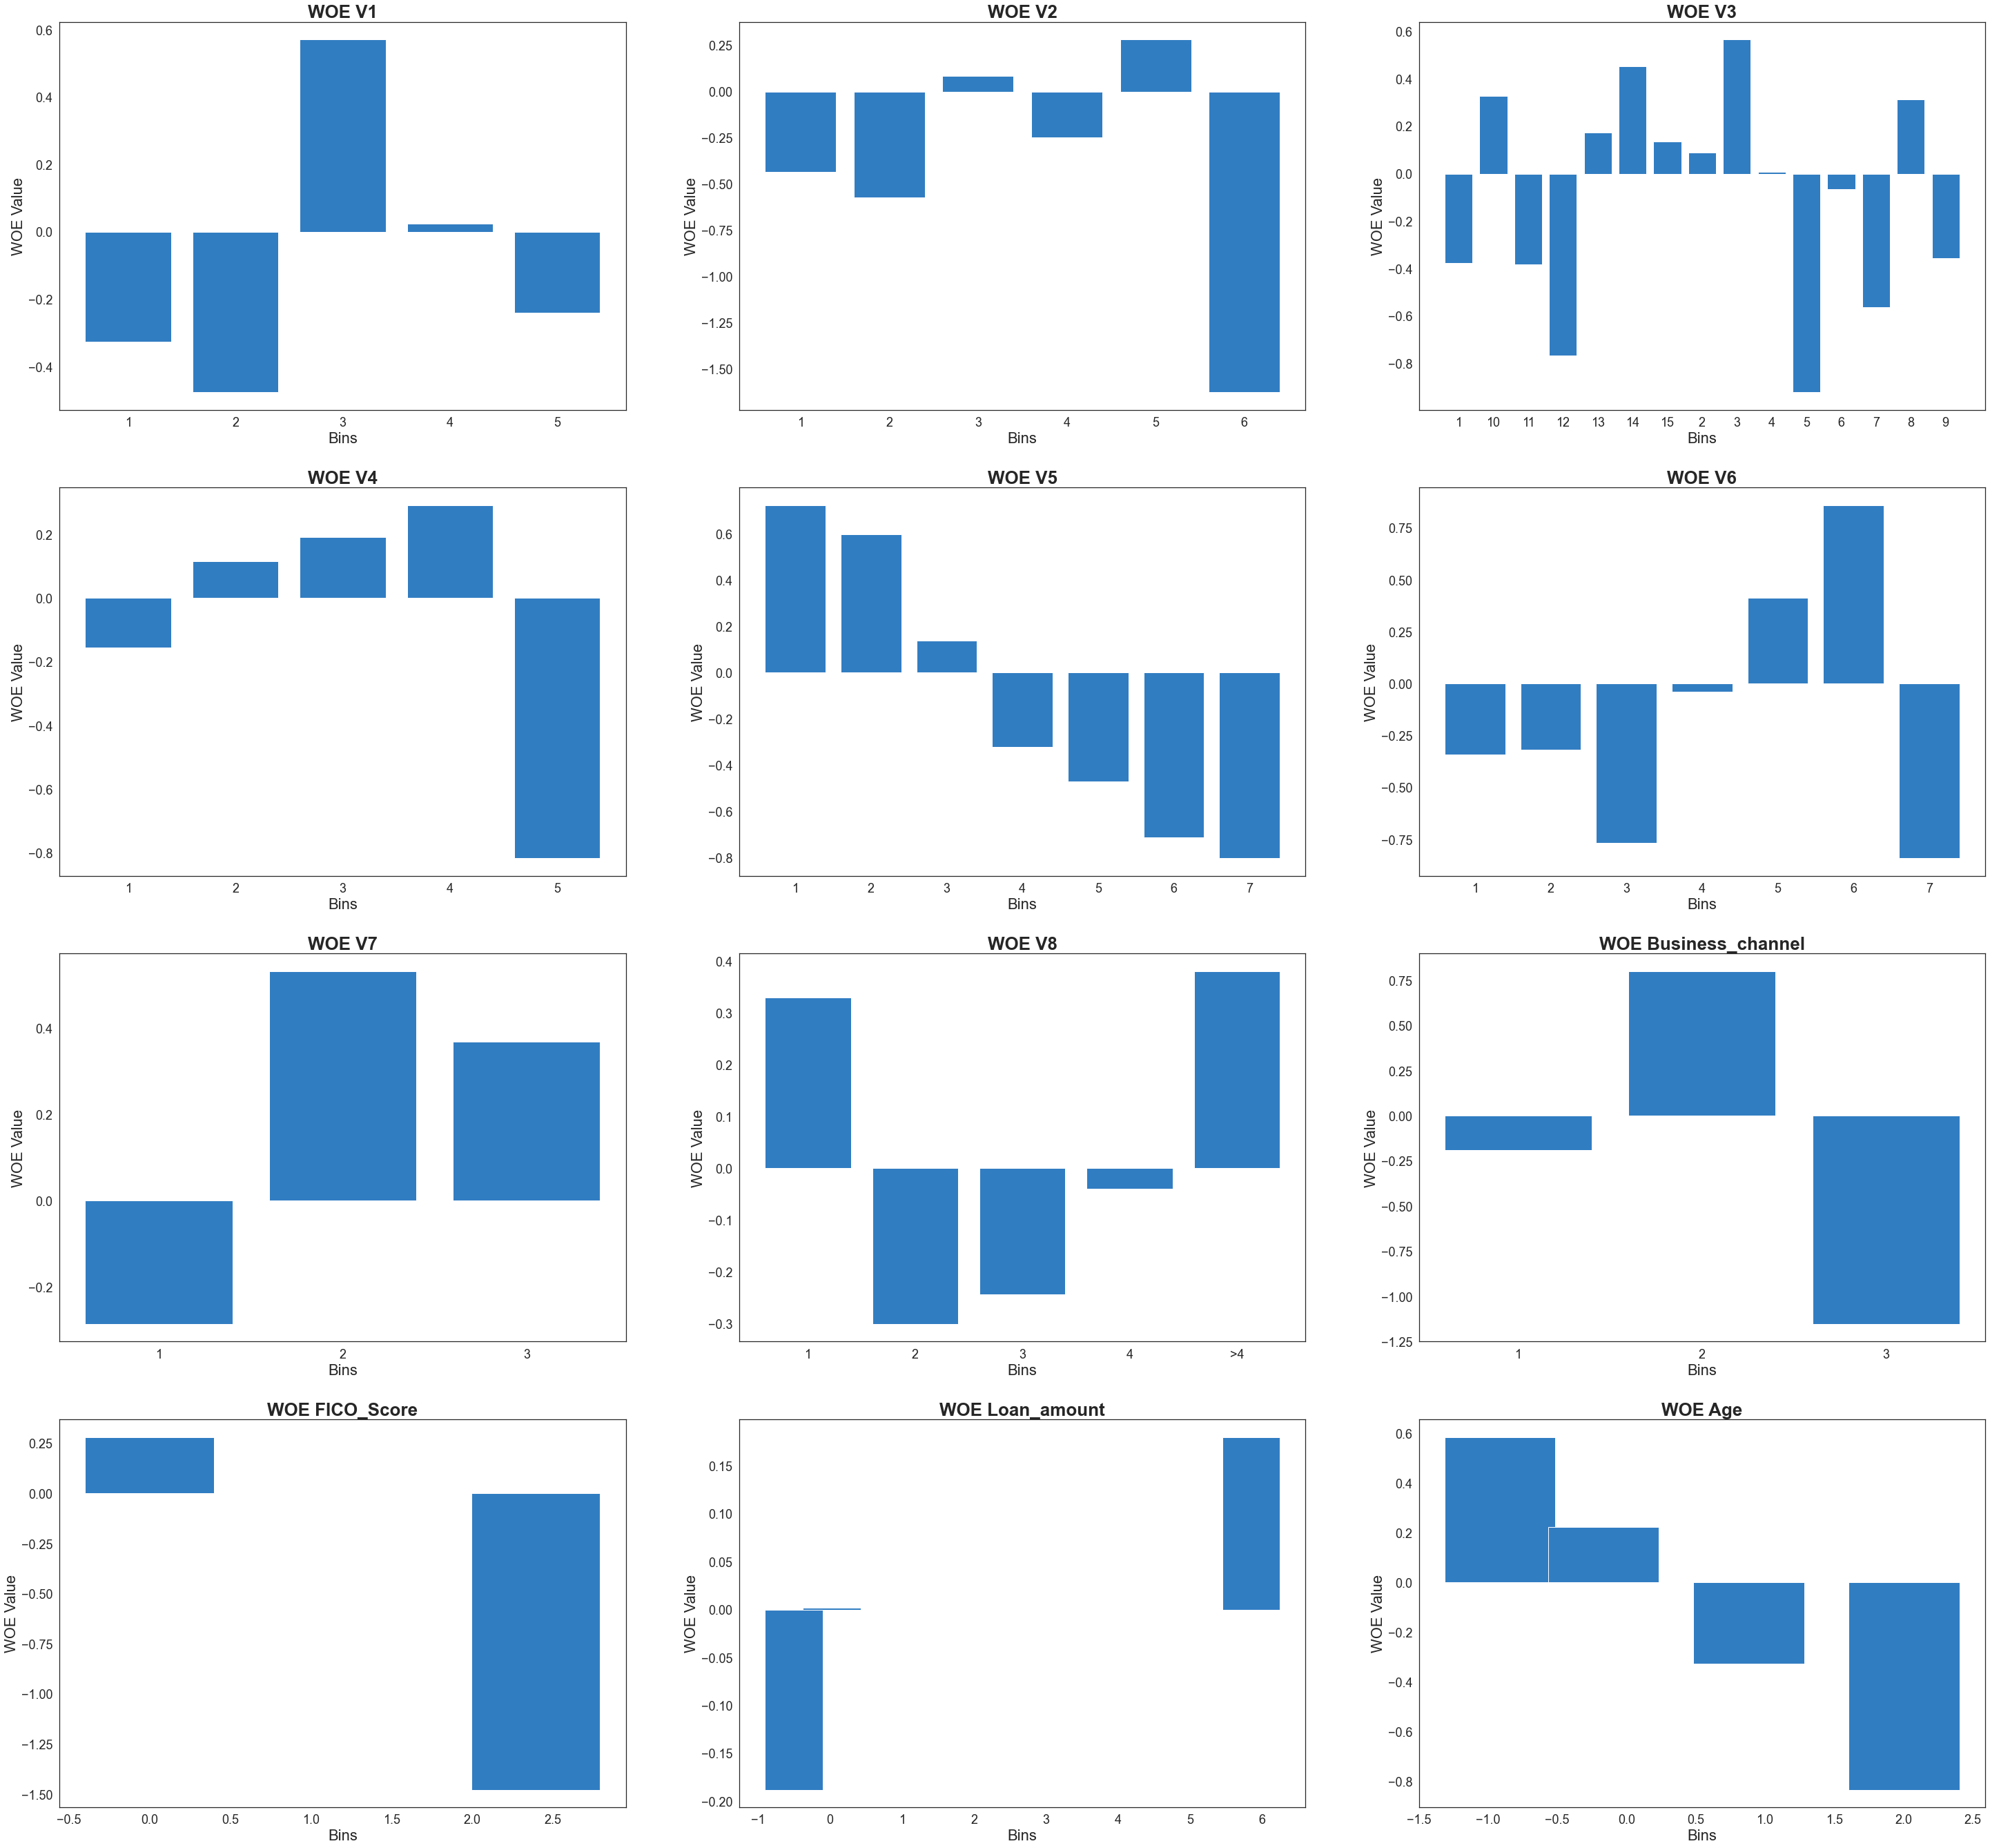

In [121]:
plt.subplots(1, 13, figsize=(50, 60))
var_names = final_iv['VAR_NAME'].unique().tolist()
for i in range(len(var_names)):
    x = final_iv[final_iv['VAR_NAME'] == var_names[i]]
    plt.subplot(5,3,i+1)
    plt.bar(x['MAX_VALUE'], x['WOE'], color = '#317DC2')
    plt.title('WOE '+var_names[i], fontweight="bold", fontsize=26)
    plt.xlabel('Bins', fontsize=22)
    plt.ylabel('WOE Value', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

Below are shown the Attributes within each Characteristic that influence negatively the probability of defaulting. It's clear by looking at the graph above and the table below that for instance, the  higher the age, the lower the probability of defaulting. Whereas in loan amount, the higher the the amount loaned, the higher the probability of defaulting.

Top negative influential attributes

In [122]:
pysqldf(""" SELECT VAR_NAME as Characteristic, MAX_VALUE as Attribute, min(WOE) as minWOE 
                    FROM final_iv 
                    GROUP BY VAR_NAME
           
        """)

,Characteristic,Attribute,minWOE
0,Age,2.005665659,-0.835253
1,Business_channel,3,-1.152822
2,FICO_Score,2.392995112,-1.478117
3,Loan_amount,-0.500163599,-0.188169
4,V1,2,-0.476482
5,V2,6,-1.626165
6,V3,5,-0.921589
7,V4,5,-0.815925
8,V5,7,-0.802709
9,V6,7,-0.840275


Top positive influential attributes

In [123]:
# Most relevant category in each variable
pysqldf(""" SELECT VAR_NAME as Characteristic, MAX_VALUE as Attribute, max(WOE) as MaxWOE 
                    FROM final_iv 
                    GROUP BY VAR_NAME
           
        """)

,Characteristic,Attribute,MaxWOE
0,Age,-0.91446911,0.586808
1,Business_channel,2,0.801855
2,FICO_Score,0.0,0.281226
3,Loan_amount,5.844611495,0.180085
4,V1,3,0.571060
5,V2,5,0.282614
6,V3,3,0.565755
7,V4,4,0.291388
8,V5,1,0.723567
9,V6,6,0.858742


# Modeling

#### Cross Validation 

Two models are used: Logistic Regression and the Decision Tree. 

These models were chosen because they are easy to explain and the financial institution is obliged to clearly explain to a customer why any decision, like rejecting a loan, was taken. Therefore, other more complex models were excluded. 

Also, hyperparameter tunning is applied to both models to find the best set of hyperparameters that can boost the performance. 

Hyperparameters

In [124]:
#Logistic Regression
lr = LogisticRegression()
c_space = np.logspace(-5, 0.5, 8, 15, 20)
lrParams = {'C': c_space, 'penalty' : ['l1', 'l2']}

# Decision Tree
tree = DecisionTreeClassifier()
treeParam = {'criterion' : ['gini', 'entropy'], 'max_depth' : [4, 6, 8]}

Cross Validation

In [125]:
# ********************* Hyperparameter Tunning ******************
random.seed(30)
#list of models for loop
models = (tree, lr)
models2 = ('Tree', 'Logistic Regression_1')
#list of param for loop
param = (treeParam, lrParams)

#List to append results
auc = []
accuracy = []
modelparam= []
recall = []
precision = []
f1 = []

for i in range(len(models)):
    #Loop list of models and its parameters
    cv = GridSearchCV(models[i], param[i], cv=4)
    #Train model with train set
    cvModel = cv.fit(X_train, y_train)
    
    #Train:
    #Get probabilitie predictions on train
    preds_train = cvModel.predict_proba(X_train)[:,1]
    #Get numeric prediction on tran
    predi_num_t = cvModel.predict(X_train)
    
    #Test
    #Get probability predictions on test
    preds = cvModel.predict_proba(X_test)[:,1]
    #Get numeric prediction on test
    predi_num = cvModel.predict(X_test)
    
    
    #Save best model
    #save predictions of number of train
    #save probability predictions of Train
    #save predictions of number of test
    #save probability predictions of Test
    if i == 0: 
        model1 = cvModel
        pred1_num_t = predi_num_t
        pred1_t = preds_train
        pred1_num = predi_num
        pred1 = preds
    elif i == 1:
        model2 = cvModel
        pred2_num_t = predi_num_t
        pred2_t = preds_train
        pred2_num = predi_num
        pred2 = preds
    elif i == 2: 
        model3 = cvModel
        pred3_num_t = predi_num_t
        pred3_t = preds_train
        pred3_num = predi_num
        pred3 = preds
    elif i == 3: 
        model4 = cvModel
        pred4_num_t = predi_num_t
        pred4_t = preds_train
        pred4_num = predi_num 
        pred4 = preds
    else:
        model5 = cvModel
        pred5_num_t = predi_num_t
        pred5_t = preds_train
        pred5_num = predi_num
        pred5 = preds

    #METRICS
    #AUC
    test_roc_auc = roc_auc_score(y_test, preds)
    auc.append(roc_auc_score(y_test, preds))
    #Accuracy
    accuracy.append(cvModel.score(X_test, y_test))
    #Parameters best model
    modelparam.append(cvModel.best_estimator_)
    #Classification Report (precision    recall  f1-score   support)
    recall.append(recall_score(y_test,predi_num))
    precision.append(precision_score(y_test,predi_num))
    f1.append(f1_score(y_test,predi_num))
    print(models2[i])
        
#Creating Dataframe Metrics
metrics = pd.DataFrame(list(zip(models2,auc, accuracy, recall, precision,f1, modelparam )), columns =['Models', 'AUC','Accuracy','Recall','Precision','F1','Param']) 

#Round and Numeric variables
for x in metrics.iloc[:,1:6].columns:
     metrics[x] = round(metrics[x],3)
metrics

Tree


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\

Logistic Regression_1


,Models,AUC,Accuracy,Recall,Precision,F1,Param
0,Tree,0.733,0.785,0.182,0.569,0.276,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,Logistic Regression_1,0.755,0.782,0.152,0.560,0.240,"LogisticRegression(C=0.04036819121749321, clas..."


By looking at the AUC and the Accuracy of the model, it's clear that both model have a good performance and are very similar. However, the recall is very important in credit scoring, so other techniques most be evaluated to improve that metric. 

#### Oversampling 

The oversampling method SMOTE is applied below. The new balance is set to be 50% - 50% 

In [126]:
#OverSampling with SMOTE
method = SMOTE(sampling_strategy=1) # making 50-50 difference
# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

#Changing variable names back 
names = X_train.columns
X_train_o = pd.DataFrame(X_resampled, columns = names)
y_train_o = pd.DataFrame(y_resampled, columns = ['Default_45'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#### Cross Validation 2

In [222]:
# ********************* Hyperparameter Tunning ******************
random.seed(30)
#list of models for loop
models = (tree, lr)
models2 = ('Tree', 'Logistic Regression_O')
#list of param for loop
param = (treeParam, lrParams)

#List to append results
auc = []
accuracy = []
modelparam= []
recall = []
precision = []
f1 = []

for i in range(len(models)):
    #Loop list of models and its parameters
    cv = GridSearchCV(models[i], param[i], cv=4)
    #Train model with train set
    cvModel = cv.fit(X_train_o, y_train_o)
    
    #Train:
    #Get probabilitie predictions on train
    preds_train = cvModel.predict_proba(X_train_o)[:,1]
    #Get numeric prediction on tran
    predi_num_t = cvModel.predict(X_train_o)
    
    #Test
    #Get probability predictions on test
    preds2 = cvModel.predict_proba(X_test)[:,1]
    #Get numeric prediction on test
    predi_num = cvModel.predict(X_test)
    
    
    #Save best model
    #save predictions of number of train
    #save probability predictions of Train
    #save predictions of number of test
    #save probability predictions of Test
    if i == 0: 
        model1_o = cvModel
        pred1_num_t = predi_num_t
        pred1_t = preds_train
        pred1_num = predi_num
        pred1 = preds2
    elif i == 1:
        model2_o = cvModel
        pred2_num_t = predi_num_t
        pred2_t = preds_train
        pred2_num = predi_num
        pred2 = preds2
    elif i == 2: 
        model3 = cvModel
        pred3_num_t = predi_num_t
        pred3_t = preds_train
        pred3_num = predi_num
        pred3 = preds
    elif i == 3: 
        model4 = cvModel
        pred4_num_t = predi_num_t
        pred4_t = preds_train
        pred4_num = predi_num 
        pred4 = preds
    else:
        model5 = cvModel
        pred5_num_t = predi_num_t
        pred5_t = preds_train
        pred5_num = predi_num
        pred5 = preds

    #METRICS
    #AUC
    auc.append(roc_auc_score(y_test, preds2))
    #Accuracy
    accuracy.append(cvModel.score(X_test, y_test))
    #Parameters best model
    modelparam.append(cvModel.best_estimator_)
    #Classification Report (precision    recall  f1-score   support)
    recall.append(recall_score(y_test,predi_num))
    precision.append(precision_score(y_test,predi_num))
    f1.append(f1_score(y_test,predi_num))
    print(models2[i])
        
#Creating Dataframe Metrics
metrics_o = pd.DataFrame(list(zip(models2,auc, accuracy, recall, precision,f1, modelparam )), columns =['Models', 'AUC','Accuracy','Recall','Precision','F1','Param']) 

#Round and Numeric variables
for x in metrics_o.iloc[:,1:6].columns:
     metrics_o[x] = round(metrics_o[x],3)
metrics_o

Tree


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was exp

Logistic Regression_O


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was exp

,Models,AUC,Accuracy,Recall,Precision,F1,Param
0,Tree,0.708,0.699,0.524,0.379,0.439,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,Logistic Regression_O,0.755,0.658,0.741,0.370,0.494,"LogisticRegression(C=0.04036819121749321, clas..."


Firstly, the logistic regression aas shown in the ROC curve graph below had a better performance than the Decision Tree model. The llater had an AUC of 0.708 and while the former 0.755, a difference of almost 0.05. Therefore, the Logistic Regression is chosen as the best model and the one to conduct the Rejection Inference. 

The oversampling technique SMOTE applied, balancing the Target variable to 50 - 50 improved dramatically the recall. It was 0.152 on the previous model with unbalanced data and now the recal is 0.744 with balanced data. An improvement of 0.592. 

In other words, this improvement means that now the model identifies more accurately the defaulters. Before, the model was identifying very well the non-defaulters and because the data was unbalanced it still had a good AUC. Now, the coin is flipped. The model kept its AUC performance and improve its recall.

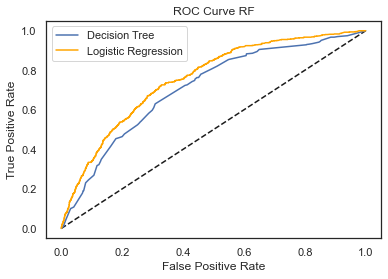

In [223]:
#PLOT of TRAIN and TEST ROC RF (second best performer)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred1)
fpr2, tpr2, thresholds2 = roc_curve(y_test,pred2)


# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label= "Decision Tree")
plt.plot(fpr2, tpr2, label = "Logistic Regression", color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RF')
plt.legend()
plt.show()

In [224]:
metrics_o

,Models,AUC,Accuracy,Recall,Precision,F1,Param
0,Tree,0.708,0.699,0.524,0.379,0.439,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,Logistic Regression_O,0.755,0.658,0.741,0.370,0.494,"LogisticRegression(C=0.04036819121749321, clas..."


# Reject Inference Method

This method allows the model to be less bias and gives an extra generalization power since it is not being fitted only with information of accepted loans but also with information of people rejected in the past. 

WoE

In [128]:
# Droping 
rejects.drop(columns='ID', inplace=True)

In [129]:
rejects.head()

,V1,V2,V3,V4,V5,V6,V7,V8,Business_channel,FICO_Score,Loan_amount,Age
0,0.57106,0.084927,0.453277,0.115998,0.723567,0.413884,-0.286570,0.329981,-0.187693,0.281226,0.001635,0.586808
1,-0.32638,-0.248374,-0.561685,-0.155063,-0.712306,-0.037346,-0.286570,-0.300847,-0.187693,-1.478117,0.180085,-0.327576
2,-0.32638,-0.248374,0.326629,0.291388,-0.471313,-0.037346,-0.286570,-0.039611,-1.152822,-1.478117,-0.188169,0.224389
3,-0.32638,0.282614,0.453277,0.115998,0.596655,0.413884,0.367956,-0.243470,-0.187693,0.281226,-0.188169,0.586808
4,-0.32638,-0.248374,0.136104,-0.155063,-0.471313,-0.037346,-0.286570,-0.243470,0.801855,-1.478117,0.180085,-0.327576


Prediction: 

Below the best model from the last Cross Validation (Logistic Regression) is used here to predict on the Reject data set to create a target variable. 

A hard Cut-Off of 75% is used since is commonly used in the industry. 

In [130]:
# Getting probabilities of default  
reject_predi_proba = model2_o.predict_proba(rejects)[:,1]

# Adding as a variable the new probabilities
rejects['Default_45'] = reject_predi_proba

In [131]:
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25,
 0.2, 0.15, 0.1, 0.05]

In [132]:
# Populate the arrays for the strategy table with a for loop
thresholds = []
for rate in accept_rates:
    # Calculate the threshold for the acceptance rate
    thresh = np.quantile(rejects['Default_45'], rate).round(5)
    # Add the threshold value to the list of thresholds
    thresholds.append(np.quantile(rejects['Default_45'] , rate).round(5))

In [133]:
strat_df = pd.DataFrame(zip(accept_rates, thresholds),
                        columns = ['Acceptance Rate','Threshold'])
# Print the entire table
strat_df

,Acceptance Rate,Threshold
0,1.00,0.89281
1,0.95,0.72458
2,0.90,0.69005
3,0.85,0.65711
4,0.80,0.62745
5,0.75,0.59768
6,0.70,0.57166
7,0.65,0.54568
8,0.60,0.51680
9,0.55,0.48894


In [134]:
# Applying a hard cut of to label each observation
rejects['Default_45']= rejects['Default_45'].apply(lambda x: 1 if x > 0.24609 else 0)

In [135]:
# Checcking the balance of the new target variable
rejects['Default_45'].value_counts()

1    3669
0    1331
Name: Default_45, dtype: int64

In [136]:
# Checking that have same number of columns
print(X_train.shape)
print(rejects.shape)

(7000, 12)
(5000, 13)


In [137]:
# Checking that the columns have the same order and are the same
print(X_train.columns)
print(rejects.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'Business_channel',
       'FICO_Score', 'Loan_amount', 'Age'],
      dtype='object')
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'Business_channel',
       'FICO_Score', 'Loan_amount', 'Age', 'Default_45'],
      dtype='object')


In [138]:
# Putting back the target variable to concatenate train set with rejects set. 
X_train = X_train.assign(Default_45=y_train)

In [139]:
# Combining Train set of accepts with Rejects
frames = [rejects, X_train]
X_inference = pd.concat(frames)

In [140]:
# Checking balance of target variable
X_inference['Default_45'].value_counts()

0    6643
1    5357
Name: Default_45, dtype: int64

#### Modeling 2

A new model will be fitted on the X_inference data set since it has the information of both accepted and rejected. 

In this step Cross Validation will be applied again to find the best hyperparameters of Decicion Tree Classifier and Logistic Regression and choose the model that performs the best . 



In [141]:
# Saving target variable and dropping it from train set
y_inference = X_inference['Default_45']
X_inference.drop(columns=['Default_45'], inplace=True)

#### Cross Validation

In [208]:
# ********************* Hyperparameter Tunning ******************
random.seed(30)
#list of models for loop
models = (tree, lr)
models2 = ('Tree', 'Logistic Regression_2')
#list of param for loop
param = (treeParam, lrParams)

#List to append results
auc = []
accuracy = []
modelparam= []
recall = []
precision = []
f1 = []

for i in range(len(models)):
    #Loop list of models and its parameters
    cv = GridSearchCV(models[i], param[i], cv=4)
    #Train model with train set
    cvModel = cv.fit(X_inference, y_inference)
    
    #Train:
    #Get probabilitie predictions on train
    preds_train = cvModel.predict_proba(X_inference)[:,1]
    #Get numeric prediction on tran
    predi_num_t = cvModel.predict(X_inference)
    
    #Test
    #Get probability predictions on test
    preds = cvModel.predict_proba(X_test)[:,1]
    #Get numeric prediction on test
    predi_num = cvModel.predict(X_test)
    
    
    #Save best model
    #save predictions of number of train
    #save probability predictions of Train
    #save predictions of number of test
    #save probability predictions of Test
    if i == 0: 
        model1 = cvModel
        pred1_num_t = predi_num_t
        pred1_t = preds_train
        pred1_num = predi_num
        pred1 = preds
    elif i == 1:
        model2 = cvModel
        pred2_num_t = predi_num_t
        pred2_t = preds_train
        pred2_num = predi_num
        pred2 = preds
    elif i == 2: 
        model3 = cvModel
        pred3_num_t = predi_num_t
        pred3_t = preds_train
        pred3_num = predi_num
        pred3 = preds
    elif i == 3: 
        model4 = cvModel
        pred4_num_t = predi_num_t
        pred4_t = preds_train
        pred4_num = predi_num 
        pred4 = preds
    else:
        model5 = cvModel
        pred5_num_t = predi_num_t
        pred5_t = preds_train
        pred5_num = predi_num
        pred5 = preds

    #METRICS
    #AUC
    test_roc_auc = roc_auc_score(y_test, preds)
    auc.append(roc_auc_score(y_test, preds))
    #Accuracy
    accuracy.append(cvModel.score(X_test, y_test))
    #Parameters best model
    modelparam.append(cvModel.best_estimator_)
    #Classification Report (precision    recall  f1-score   support)
    recall.append(recall_score(y_test,predi_num))
    precision.append(precision_score(y_test,predi_num))
    f1.append(f1_score(y_test,predi_num))
    print(models2[i])
        
#Creating Dataframe Metrics
metrics_2 = pd.DataFrame(list(zip(models2,auc, accuracy, recall, precision,f1, modelparam )), columns =['Models', 'AUC','Accuracy','Recall','Precision','F1','Param']) 

#Round and Numeric variables
for x in metrics_2.iloc[:,1:6].columns:
     metrics_2[x] = round(metrics_2[x],3)
metrics_2

Tree


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\

Logistic Regression_2


,Models,AUC,Accuracy,Recall,Precision,F1,Param
0,Tree,0.71,0.560,0.854,0.321,0.467,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,Logistic Regression_2,0.75,0.633,0.762,0.354,0.483,"LogisticRegression(C=0.04036819121749321, clas..."


The graph below shows the ROC curve of the Decision Tree and the Logistic Regression. Despite having similar performances, the Logistic has a slightly better AUC, as can be seen in the table below, with a 0.75 so this model will be chosen. 

The results of the this model are satisfactory. After applying rejection inference, it can be said that the model is reliable because it kept a competitive AUC, accuracy and Recall and is even more simple that the previous model because it didn't require oversampling.



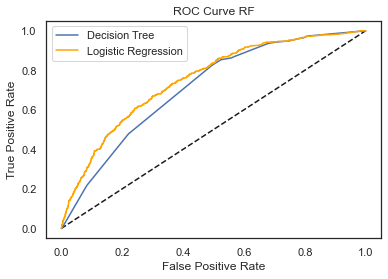

In [209]:
#PLOT of TRAIN and TEST ROC RF (second best performer)

# Generate ROC curve values: fpr, tpr, thresholds
fpr2, tpr2, thresholds2 = roc_curve(y_test,pred2)
fpr, tpr, thresholds = roc_curve(y_test, pred1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label= "Decision Tree")
plt.plot(fpr2, tpr2, label = "Logistic Regression", color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RF')
plt.legend()
plt.show()

In [210]:
metrics_2

,Models,AUC,Accuracy,Recall,Precision,F1,Param
0,Tree,0.71,0.560,0.854,0.321,0.467,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
1,Logistic Regression_2,0.75,0.633,0.762,0.354,0.483,"LogisticRegression(C=0.04036819121749321, clas..."


# Comparison

The table below shows the different performance metrics of three models. The first one, Logistic Regression_1 is the model fitted only on accepted applications. The second one, Logistic Regression_O, is fitted on oversample data using SMOTE and the third if fitted on both Accepted and Rejected applications. 

In general the three models have similar performances. However, the recall changes drastically from model one to model two and three. It can be infer that the recall increased because of a less unbalanced data in the latter models. 

In conclusion, even by comparing the rejection inference model (Logistic Regression_2) with the second model, it can be said that its performance is very robust because the both AUC and Accuracy are very similar and its Recall is higher. The last mentioned metric is very important in the kind of problem that this project is tacking because it measures how good the model is correctly identifying the 1 or the defaulters. Therefore, having this metric as high as possible is desirable. 



In [159]:
x = pd.DataFrame([metrics.iloc[1,0:6], metrics_o.iloc[1,0:6], metrics_2.iloc[1,0:6]])
x

,Models,AUC,Accuracy,Recall,Precision,F1
1,Logistic Regression_1,0.755,0.782,0.152,0.560,0.240
1,Logistic Regression_O,0.755,0.658,0.741,0.370,0.494
1,Logistic Regression_2,0.750,0.633,0.762,0.354,0.483


The graph below shows the ROC curve of both oversample and rejection inference models. Both model have almost an identical performance. The big difference is the recall that can be seen in the next below.

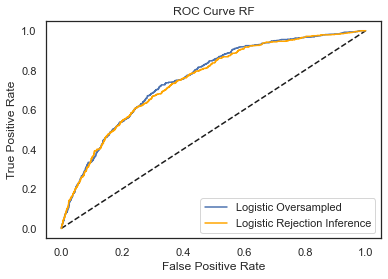

In [158]:
#PLOT of TRAIN and TEST ROC RF (second best performer)

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, preds2)
fpr2, tpr2, thresholds = roc_curve(y_test,preds)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label= "Logistic Oversampled")
plt.plot(fpr2, tpr2, label = "Logistic Rejection Inference", color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RF')
plt.legend()
plt.show()

In [195]:
b=x['Recall'].tolist()
b
x = pd.DataFrame([b], columns=['Model 1', 'Logistic with Oversample', 'Logistic with Rejection Inference'])

The graph below shows the recall of each model. It's visually clear that the green bar, which is the model with rejection inference, is performing extremely well since it even has a higher recall that the oversample model method. 

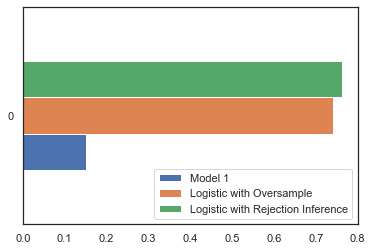

In [198]:
x.plot(kind='barh')

Below are the parameters of the best model (number two)

In [144]:
model2.best_estimator_

LogisticRegression(C=0.04036819121749321, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Scorecard

To make the results easy to understand for any person in the corporation the results of the models, that output will be translated into a Credit Scorecard. 

The scorecard created here will help the decision maker decide if a customer is eligible for a loan or not by only summing up his corresponding attributes. If the total sum is equal or higher to 600 points, then the customer is eligible.  

https://towardsdatascience.com/intro-to-credit-scorecard-9afeaaa3725f
https://medium.com/@yanhuiliu104/credit-scoring-scorecard-development-process-8554c3492b2b



<br/>

Here are the parameters needed to build the scorecard. In this case, the process is conducted following two online examples. The link is found at the top. 


<br/>


Score_i= (βi × WoE_i + α/n) × Factor + Offset/n

Where:

βi — logistic regression coefficient for the variable Xi

α — logistic regression intercept

WoE — Weight of Evidence value for variable Xi

n — number of independent variable Xi in the model

Factor, Offset — known as scaling parameter, where

PDO = Points to double the odds 

Factor = pdo/ln(2)

Offset = Target Score — (Factor × ln(Target Odds))

<br/>

For this scorecard, 600 points correspond to good/bad odds of 50 to 1 and an increase of the score of 20 points corresponds to a doubling of the good/bad odds. 

### Computation

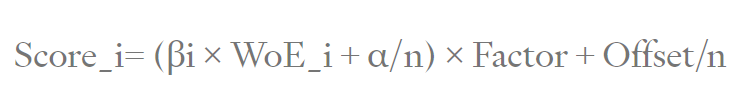

In [145]:
# Setting the parameters
# Coefficients
bi = model2.best_estimator_.coef_
bi = bi[0]

# Intercept
a = model2.best_estimator_.intercept_
a = a[0]

# Number of variables
n = len(X_test.columns)

# Points to double the odds
pdo = 20

factor = pdo/ln(2)
offset = 600 - (factor*ln(50))

In [146]:
# Putting again the Characteristic which are the boundaries of each category
final_iv['Characteristic'] = final_iv['VAR_NAME']

In [147]:
# Changing the names 
final_iv.rename({'VAR_NAME':'Coefficient', 'MAX_VALUE':'Attribute'}, inplace=True, axis=1)

In [148]:
# Dictionary to put the respective coefficient for each category 
keys_names = final_iv['Coefficient'].unique().tolist()
values_coefficient = bi
dictionary_coefficients = dict(zip(keys_names, values_coefficient))
print(dictionary_coefficients)

{'V1': 0.08857218852609847, 'V2': 0.45761891479286565, 'V3': 0.39804737887838104, 'V4': 0.36148358260085545, 'V5': 0.5535215015407338, 'V6': 0.09795114494663097, 'V7': 0.43573139971175523, 'V8': 0.23407754044405085, 'Business_channel': 0.576875395423586, 'FICO_Score': 0.8423146139359244, 'Loan_amount': 0.007653749553065322, 'Age': 0.07039907501988606}


In [149]:
# Putting the coefficient matching each category
final_iv['Coefficient'].replace(dictionary_coefficients, inplace = True)

In [150]:
# Calculating the score 
final_iv['Score'] = (((final_iv['Coefficient'] * final_iv['WOE']) + a/n) * factor )+ offset/n

In [151]:
# Creating the final dataframe with the Scorecard 
scorecard = final_iv[['Characteristic','Attribute','Score']]

In [152]:
scorecard[['Attribute','Score']]= round(scorecard[['Attribute','Score']],4)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### Visualization

Below are the 10 most important variables. In other words, this are the variables that decrease the probability of defaulting or are the attributes that will boost the chance of a client of getting a loan.  

In [153]:
# 10 most relevant variables
scorecard.sort_values('Score', ascending=False)[:5]

,Characteristic,Attribute,Score
56,Business_channel,2,53.8137
31,V5,1,52.0230
32,V5,2,49.9961
58,FICO_Score,0,47.3017
46,V7,2,47.1522


In [154]:
# Most relevant category in each variable
pysqldf(""" SELECT Characteristic, Attribute, min(Score) as Score
            FROM scorecard
            GROUP BY Characteristic
        """)

,Characteristic,Attribute,Score
0,Age,2.005665659,38.7701
1,Business_channel,3,21.2779
2,FICO_Score,2.392995112,4.5425
3,Loan_amount,-0.500163599,40.4252
4,V1,2,39.2490
5,V2,6,18.9947
6,V3,5,29.8821
7,V4,5,31.9565
8,V5,7,27.6465
9,V6,7,38.0919


### Conclusion

The customer with the highest probability of getting a loan is someone not very young, with an age of 1.29 or higher. He applies usually through a partner retailer rather than through a broker. Has a high FICO_Score, better if equal or higher to 2.468. He is asking often for large loan amount, preferably of 4.45 or higher and is part of the following categories: 

- V1: 2 
- V2: 6
- V3: 5
- V4: 4
- V5: 7
- V6: 7
- V7: 1
- V8: 2

<br/>

The customermer that is less likely to get a Loan from the bank is a person that is very young, with an age up to -0.87. He often applies for loan through a broker and has a mid range FICO_score, from -3.2 to -0.366. He also applies for a medium size loan, ranging from 1.667 to 3.059 and belongs to this categories:

- V1: 3 
- V2: 5
- V3: 3
- V4: 5
- V5: 1
- V6: 6
- V7: 2
- V8: >4
    
 <br>
 
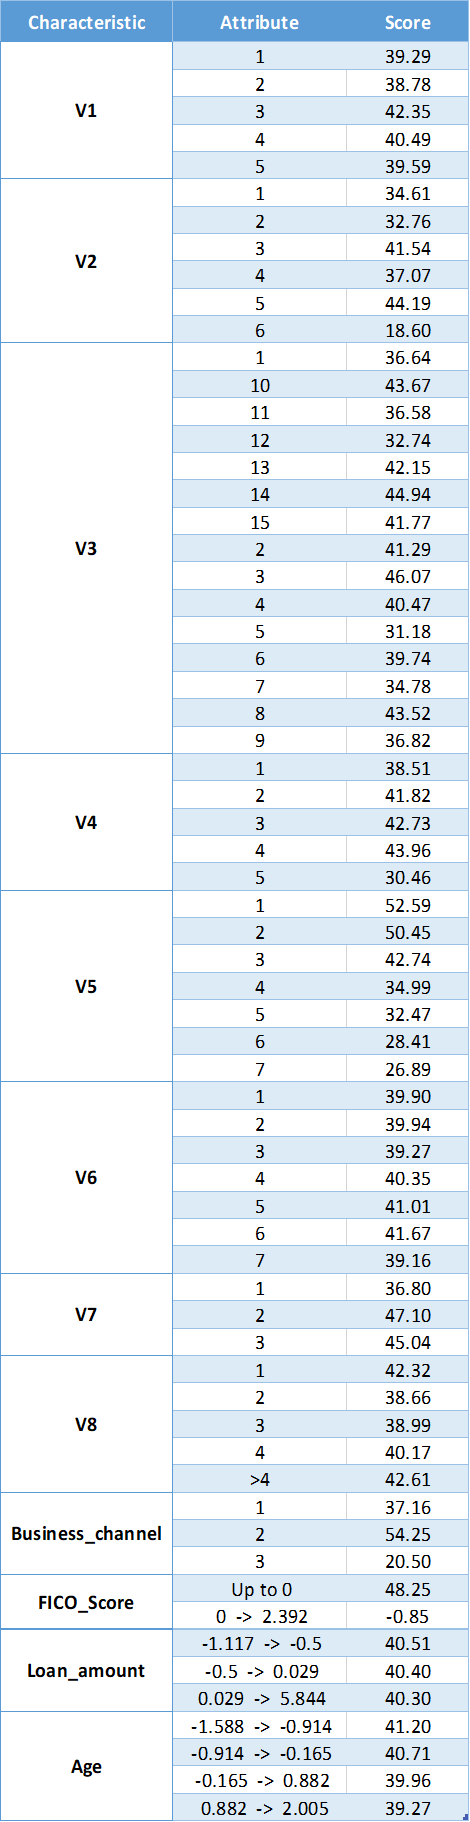